In [3]:
# structure:    fully-connected neural network
# para.pth:     ./basic_fc_gaussian.pt
# detect image: '../image/self_70.png'

# reference:  
# 1. network reference: 
#     (1) https://www.researchgate.net/publication/328619145_Recognition_of_Handwritten_Digits_Using_DNN_CNN_and_RNN_Second_International_Conference_ICACDS_2018_Dehradun_India_April_20-21_2018_Revised_Selected_Papers_Part_I
#     (2) https://blog.csdn.net/Learning_AI/article/details/122664814
# 2. split numbers: https://blog.csdn.net/qq8993174/article/details/89081859
# 3. add gaussian noise to detect image: https://www.wongwonggoods.com/python/python_opencv/opencv-add-gaussian-noise/

In [4]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random as random

In [5]:
# 用來讓 MNIST 在 transform 也加上 gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean  
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, )),
    AddGaussianNoise(0., 0.3)
])

train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 10)
        )
 
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # resize，變成一維數據
        x = self.layers(x)
        return x

In [8]:
model = Net()

In [9]:
# loss function & 更新方法
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [10]:
min_loss = np.Inf
def train(epoch):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        
        optimizer.zero_grad() # 避免上一次更新的東西沒有被清掉
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
    
        if batch_idx % 300 == 299:
            total_loss = 0.0
        
        # save model
        if loss.item() < min_loss:
            torch.save(model.state_dict(), "basic_fc_gaussian.pt")

In [11]:
def test(epoch):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("%d epoch's accuracy: %.2f %%" % (epoch + 1, 100 * correct / total))

In [12]:
if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test(epoch)

1 epoch's accuracy: 88.80 %
2 epoch's accuracy: 93.57 %
3 epoch's accuracy: 94.85 %
4 epoch's accuracy: 95.91 %
5 epoch's accuracy: 96.64 %
6 epoch's accuracy: 96.93 %
7 epoch's accuracy: 97.06 %
8 epoch's accuracy: 97.17 %
9 epoch's accuracy: 97.41 %
10 epoch's accuracy: 97.65 %


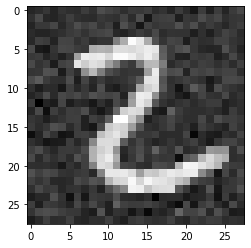

In [13]:
# 測試用：顯示 MNIST 加上 gaussian noise 後的樣子
cnt = 0
for batch_idx, data in enumerate(train_loader, 0):
    inputs, target = data

    # add salt for training set
    salt = 0.997
    pepper = 1 - salt
    for single_img in inputs:
        if cnt == 0:
            plt.imshow(single_img[0], cmap='gray')
            plt.show()
            
            cnt = cnt + 1

In [14]:
# load basic model
basic_model = Net()
basic_model.load_state_dict(torch.load("basic_fc_gaussian.pt"))

<All keys matched successfully>

In [15]:
def gaussian_noise(img, mean=0, std=0.3):
    img = img / 255
    noise = np.random.normal(mean, std, img.shape)
    gaussian_out = img + noise
    gaussian_out = np.clip(gaussian_out, 0, 1)

    # 0~1 -> 0~255
    gaussian_out = np.uint8(gaussian_out * 255)
    noise = np.uint8(noise * 255)
    return gaussian_out

In [16]:
# 反相灰度圖，將黑白閾值顛倒
def accessPiexl(img):
    height = img.shape[0]
    width = img.shape[1]
    for i in range(height):
       for j in range(width):
           img[i][j] = 255 - img[i][j]
    return img

In [17]:
# 黑白顛倒 binary 圖像
def accessBinary(img, threshold=128):
    img = accessPiexl(img)
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    _, img = cv2.threshold(img, threshold, 0, cv2.THRESH_TOZERO)
    return img

In [18]:
# 尋找邊緣，返回邊框的左上角跟右下角（利用cv2.findContours）
def findBorderContours(path, maxArea=50):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = accessBinary(img) # find countours 的輸入必須是 binary
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    borders = []
    for contour in contours:
        # 將邊緣擬合成一個邊框
        x, y, w, h = cv2.boundingRect(contour)
        if w*h > maxArea:
            border = [(x, y), (x+w, y+h)]
            borders.append(border)
    return borders

In [19]:
# 根據邊框轉成MNIST格式
def transMNIST(path, borders, size=(28, 28)):
    imgData = np.zeros((len(borders), size[0], size[0], 1), dtype='uint8')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = accessBinary(img)
    for i, border in enumerate(borders):
        borderImg = img[border[0][1]:border[1][1], border[0][0]:border[1][0]]
        # 根據最大邊擴展窄邊的像素至正方形 28*28
        extendPiexl = (max(borderImg.shape) - min(borderImg.shape)) // 2
        targetImg = cv2.copyMakeBorder(borderImg, 7, 7, extendPiexl + 7, extendPiexl + 7, cv2.BORDER_CONSTANT)
        targetImg = cv2.resize(targetImg, size)
        targetImg = np.expand_dims(targetImg, axis=-1)
        imgData[i] = targetImg
    return imgData

In [20]:
def predict(imgData):
    result_ans = []
    for img in imgData:
        img = torch.from_numpy(img).float()
        img = img.view(1, 1, 28, 28)
        img = img.to('cpu')
        outputs = basic_model(img)
        _, predicted = torch.max(outputs.data, 1)
        result_ans.append(predicted.to('cpu').numpy().squeeze())
        # see single number image after processing
        plt.imshow(img[0][0], cmap='gray', interpolation='none')
        plt.show()
    return result_ans

In [21]:
# detect picture result
def showResults(path, borders, results=None):
    img = cv2.imread(path)
    for i, border in enumerate(borders):
        cv2.rectangle(img, border[0], border[1], (0, 0, 255))
        if results:
            cv2.putText(img, str(results[i]), border[0], cv2.FONT_HERSHEY_COMPLEX, 0.8, (255, 0, 0), 1)
    cv2.imshow('detect_gaussian', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

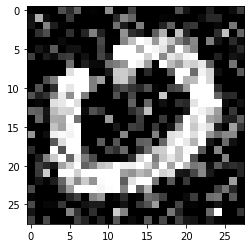

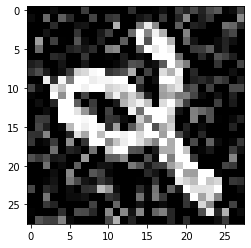

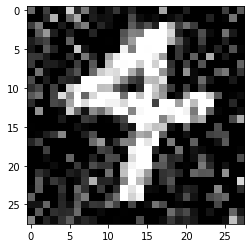

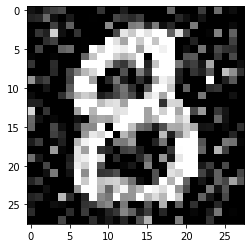

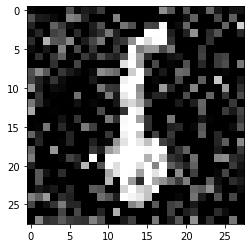

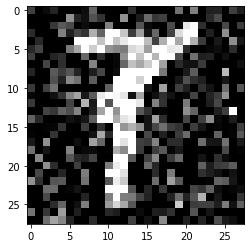

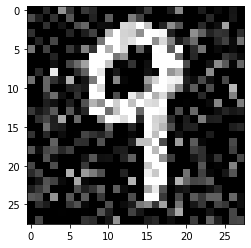

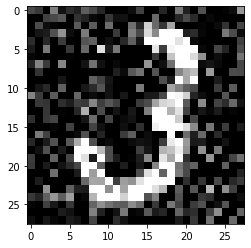

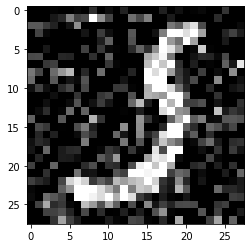

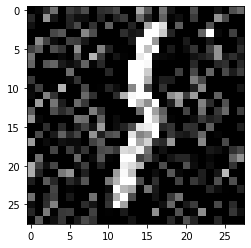

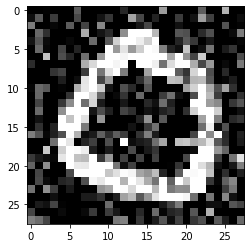

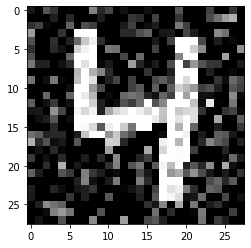

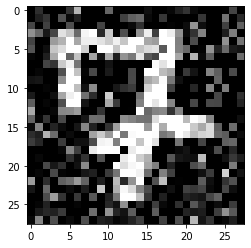

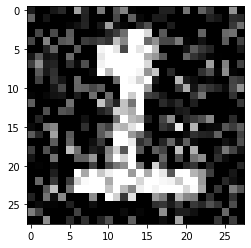

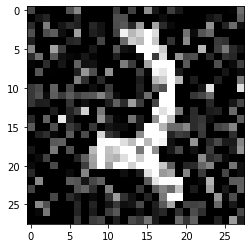

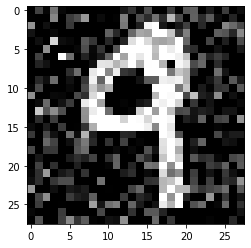

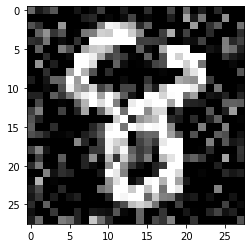

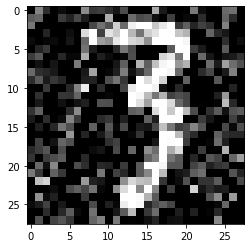

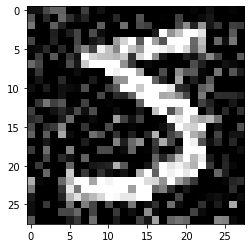

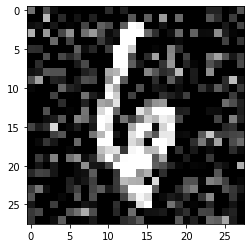

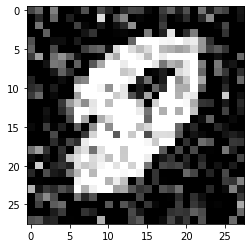

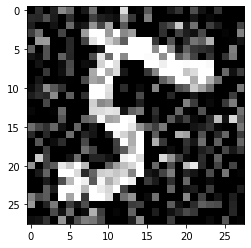

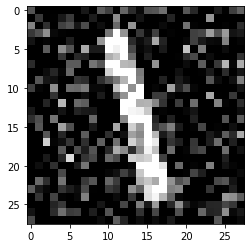

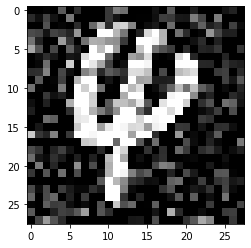

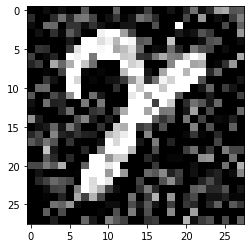

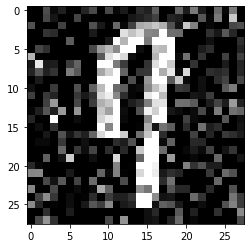

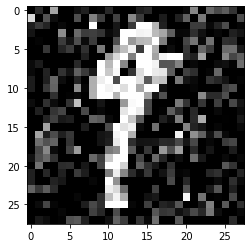

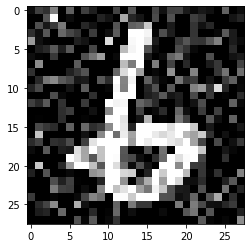

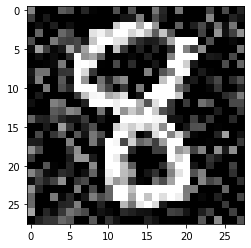

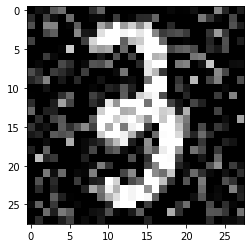

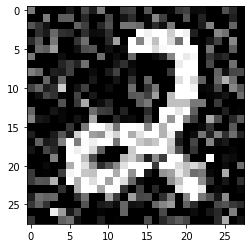

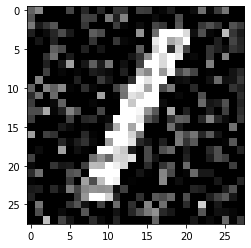

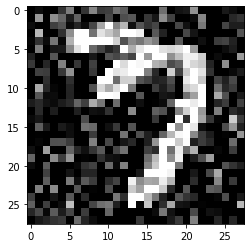

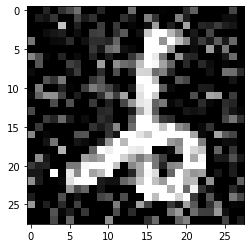

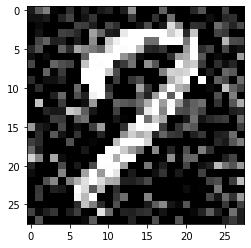

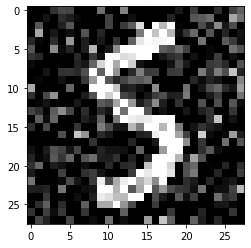

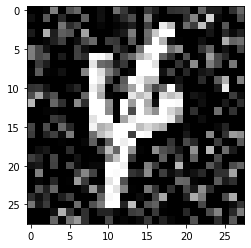

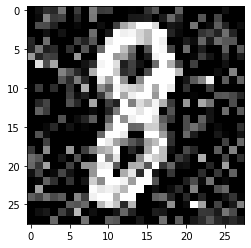

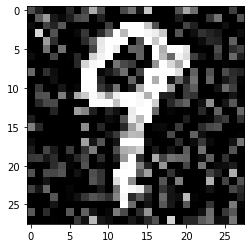

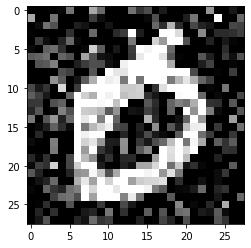

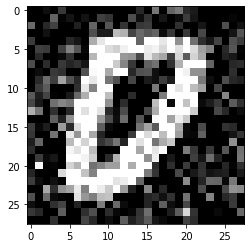

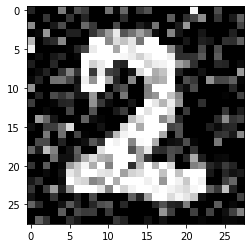

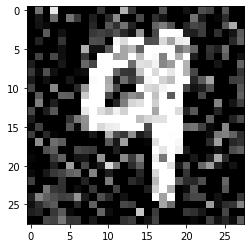

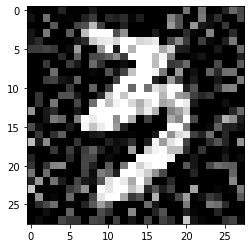

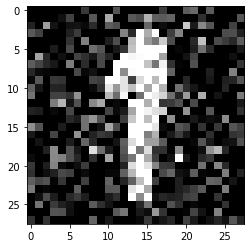

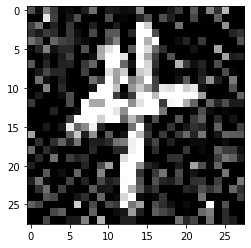

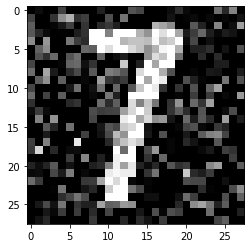

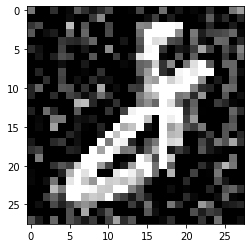

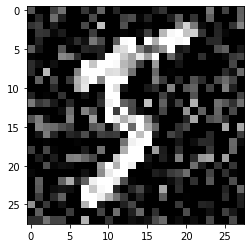

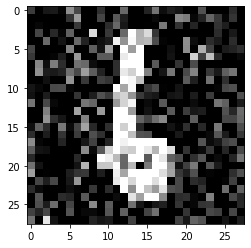

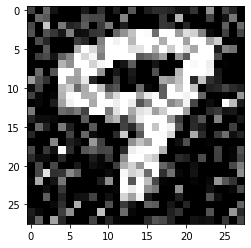

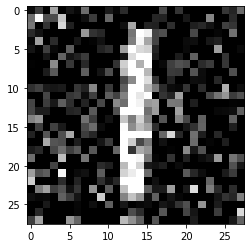

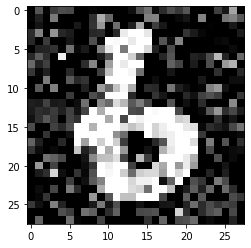

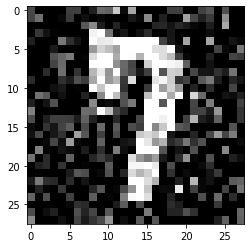

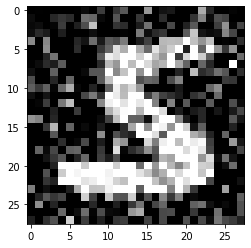

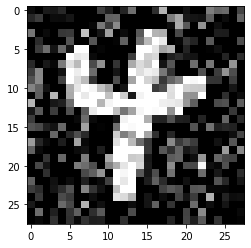

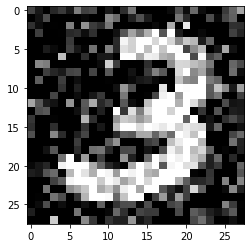

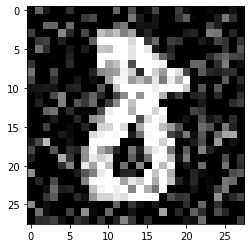

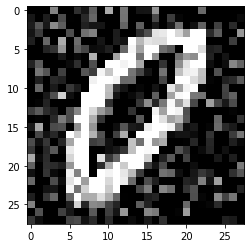

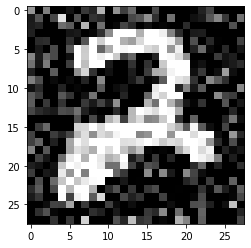

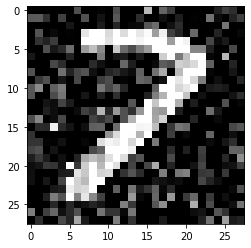

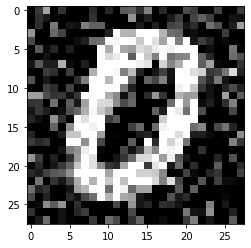

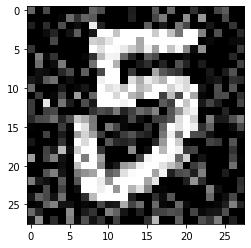

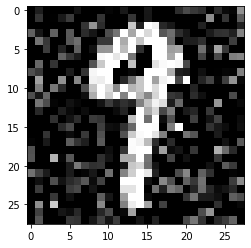

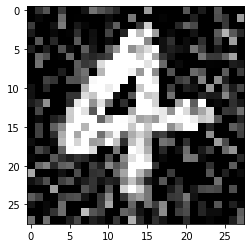

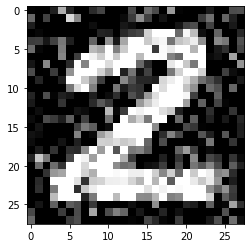

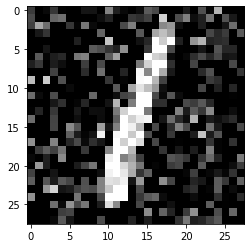

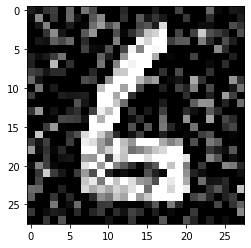

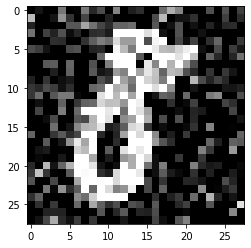

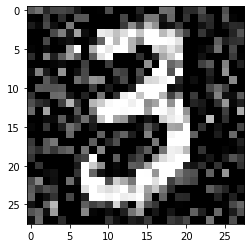

In [22]:
path = '../image/self_70.png'
borders = findBorderContours(path)  # 1. find the border for the handwriting numbers on paper
imgData = transMNIST(path, borders) # 2. transmit those images into single image with 28*28 size

gaussian_list = []  # 3. add gaussian noise to each image
for img in imgData:
    img = gaussian_noise(img)
    gaussian_list.append(img)

results = predict(gaussian_list)          # 4. determine the answer for single image
showResults(path, borders, results) # 5. show determine result with the original image marked the number